<a href="https://datamics.com/de/courses/"><img src=../DATA/bg_datamics_top.png></a>

<em text-align:center>© Datamics</em>
# Word2Vec

Der Code für diese Vorlesung basiert auf dem tollen Tutorial-Beispiel von tensorflow!

Schritt-für-Schritt-Anleitung: https://www.tensorflow.org/tutorials/word2vec

Code: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

# Schritt 0: Importe

In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

# Schritt 1: Die Daten

In [2]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Erstelle das Directory (dt. Verzeichnis), falls es nicht existiert.
    os.makedirs(words_data, exist_ok=True)
    
    # Pfad zur zip Datei 
    zip_path = os.path.join(words_data, "words.zip")
    
    # Wenn die Zip-Datei nicht vorhanden ist, laden sie vom folgenden Daten-URL herunter.
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Nun, da die Zip-Datei vorhanden ist, hole dir die Daten von der Daten.
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Gibt eine Liste aller Wörter in der Datenquelle zurück.
    return data.decode("ascii").split()

In [4]:
# Defaults verwenden (das kann eine Weile dauern!)
words = fetch_words_data()

In [5]:
# Gesamtzahl der Wörter
len(words)

17005207

In [6]:
# Zufälliger Ausschnitt an Worten
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [7]:
for w in words[9000:9040]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

## Wortanzahl erstellen

In [8]:
from collections import Counter

In [9]:
mylist = ["one",'one','two']

In [10]:
Counter(mylist)

Counter({'one': 2, 'two': 1})

In [11]:
Counter(mylist).most_common(1)

[('one', 2)]

## Word-Daten und Vokabeln erstellen

In [12]:
def create_counts(vocab_size=50000):

    # Beginne das Hinzufügen von Vokabeln mit Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    
    # In ein numpy Array umwandeln (Tuple unpacking)
    vocab = np.array([word for word, _ in vocab])
    
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [13]:
vocab_size = 50000

In [14]:
# Das kann eine Weile dauern.
data,vocabulary = create_counts(vocab_size=vocab_size)

In [15]:
data[0]

5239

In [16]:
(words[100],data[100])

('interpretations', 4188)

In [17]:
vocabulary.shape

(50000,)

In [18]:
vocabulary[np.random.randint(0,50000)]

'ida'

## Funktion für Chargen

Direkt aus der word2vec Date der TensorFlow Dokumentation:

In [19]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # Ziel label im Bufferzentrum 
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Ein wenig zurückverfolgen, um zu vermeiden, dass Wörter am Ende eines Stapels übersprungen werden.
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [20]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [21]:
batch

array([3082, 3082, 3082, 3082, 3082, 3082, 3082, 3082])

In [22]:
labels

array([[5239],
       [  11],
       [5239],
       [  11],
       [5239],
       [  11],
       [5239],
       [  11]])

## Konstanten

In [23]:
# Größe der Charge
batch_size = 128

# Dimension des Einbettungsvektors
embedding_size = 150

# Wie viele Wörter sind links und rechts zu berücksichtigen 
# (je größer, desto länger ist das Training)
skip_window = 1       

# Wie oft soll eine Eingabe wiederverwendet werden, um ein Label zu erzeugen?
num_skips = 2        

In [24]:
#Wir wählen einen zufälligen Validierungssatz aus, um die nächsten Nachbarn zu untersuchen. 
#Hier beschränken wir die Validierungsbeispiele auf die Wörter, die eine 
#niedrige numerische ID haben, die bauartbedingt auch die häufigsten sind.

# Zufällige Menge von Wörtern, um die Ähnlichkeit zu bewerten.
valid_size = 16   

# Wähle nur Dev-Samples im Kopf der Distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Anzahl der zu untersuchenden Negativbeispiele.
num_sampled = 64   

# Modell-Lernrate
learning_rate = 0.01

# Wie viele Wörter im Vokabular
vocabulary_size = 50000

## TensorFlow Platzhalter and Konstanten

In [25]:
tf.reset_default_graph()

# Input Daten.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Variablen

In [26]:
# Suche nach den Einbettungen für Eingaben. 50000 x 150 dimensionen
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [27]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE-Verlust

In [28]:
# Konstruieren der Variablen für den NCE-Verlust
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                              stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [29]:
# Berechne den durchschnittlichen NCE-Verlust für die Charge.
# tf.nce_loss erstellt automatisch eine neue Probe der negativen Labels,
# wenn wir den Verlust auswerten.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

### Optimierer

In [30]:
# Konstruiere den Adam-Optimierer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [31]:
# Berechne die Kosinusähnlichkeit zwischen Minibatch-Beispielen und allen Einbettungen.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [32]:
# Variableninitialisierer hinzufügen.
init = tf.global_variables_initializer()

# Session

In [33]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [34]:
# Normalerweise muss er ziemlich groß sein, um gute Ergebnisse zu erzielen, 
# Das Training dauert sehr lange!
num_steps = 200001 # 5000

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # Wir führen einen Update-Schritt durch, indem wir die Trainings-Operation auswerten 
        # (einschließlich der Liste der zurückgegebenen Werte für session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # Der durchschnittliche Verlust ist eine Schätzung des Verlustes über die letzten 1000 Chargen.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  278.1254577636719
Average loss at step  1000 :  10224.483907485961
Average loss at step  2000 :  22933.883399375914
Average loss at step  3000 :  27015.389865104677
Average loss at step  4000 :  30870.151921808243
Average loss at step  5000 :  35112.256438812256
Average loss at step  6000 :  38884.53103674317
Average loss at step  7000 :  38302.44784720612
Average loss at step  8000 :  44861.35717572498
Average loss at step  9000 :  44210.68512466574
Average loss at step  10000 :  46229.087992712375
Average loss at step  11000 :  42452.33505034663
Average loss at step  12000 :  47791.43528761196
Average loss at step  13000 :  47089.754692374896
Average loss at step  14000 :  42464.896587174415
Average loss at step  15000 :  45191.083922246835
Average loss at step  16000 :  45672.929660705566
Average loss at step  17000 :  42407.69600874329
Average loss at step  18000 :  42627.71133209229
Average loss at step  19000 :  41509.71691792059
Average loss at step  2

Average loss at step  166000 :  89696.43550048828
Average loss at step  167000 :  101256.01555509948
Average loss at step  168000 :  86265.14840910339
Average loss at step  169000 :  89064.88553198623
Average loss at step  170000 :  96172.5740419922
Average loss at step  171000 :  81161.68091378403
Average loss at step  172000 :  101144.29214737701
Average loss at step  173000 :  101480.62972690583
Average loss at step  174000 :  103024.65549777221
Average loss at step  175000 :  108089.6202354126
Average loss at step  176000 :  97136.2415542984
Average loss at step  177000 :  87364.11251612855
Average loss at step  178000 :  85652.49389398385
Average loss at step  179000 :  92219.27473025513
Average loss at step  180000 :  81621.75703582764
Average loss at step  181000 :  90124.90180342102
Average loss at step  182000 :  92546.51140084649
Average loss at step  183000 :  94471.84552261353
Average loss at step  184000 :  103874.52702160644
Average loss at step  185000 :  105353.00576647

# Visualisierung der Ergebnisse

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

## TSNE

* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

Die Reduzierung der Dimensionalität auf 2-D-Vektoren (von 150). Dies dauert eine Weile.

In [37]:
type(final_embeddings)

numpy.ndarray

In [38]:
final_embeddings.shape

(50000, 150)

In [39]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000) 

In [40]:
plot_only = 2000 #500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:]) 

In [41]:
labels = [vocabulary[i] for i in range(plot_only)]

In [42]:
low_dim_embs.shape

(2000, 2)

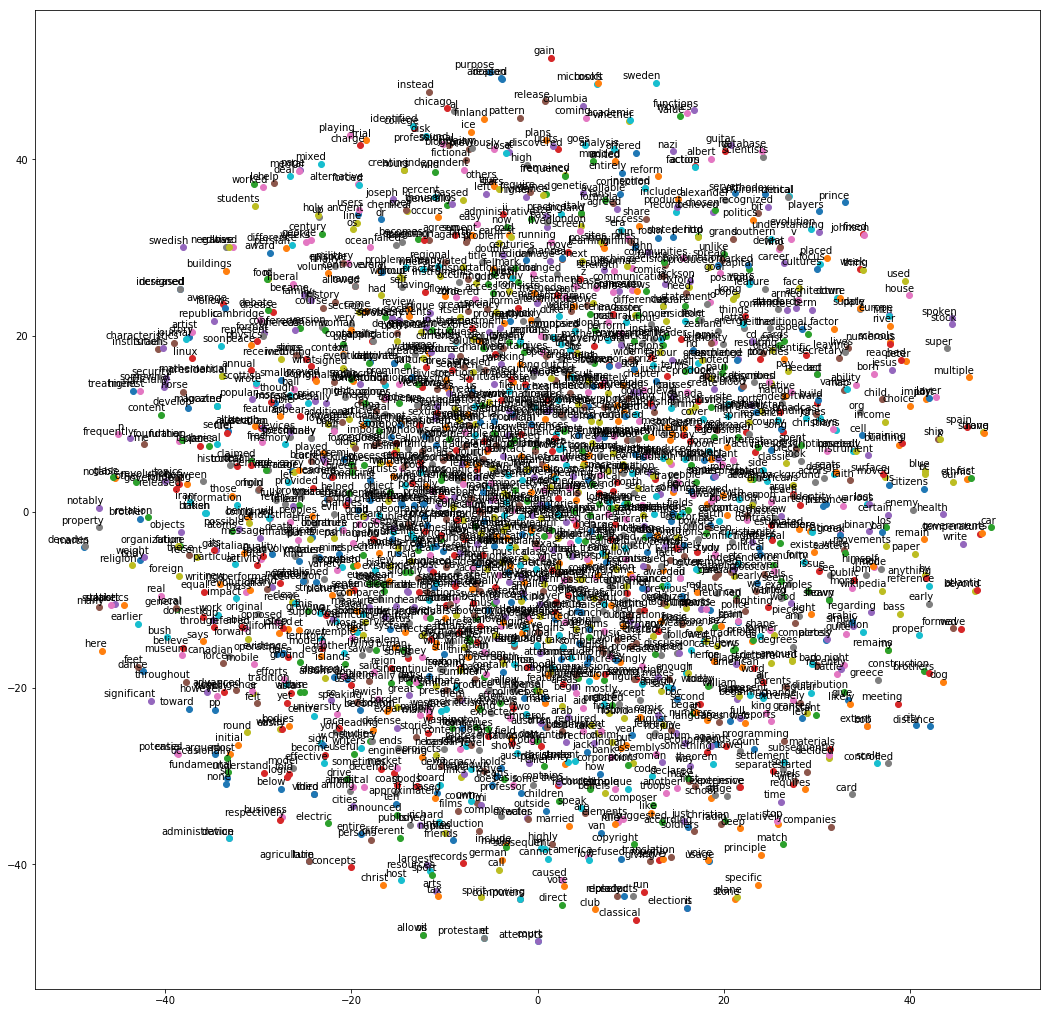

In [43]:
plot_with_labels(low_dim_embs, labels)

(-10, 10)

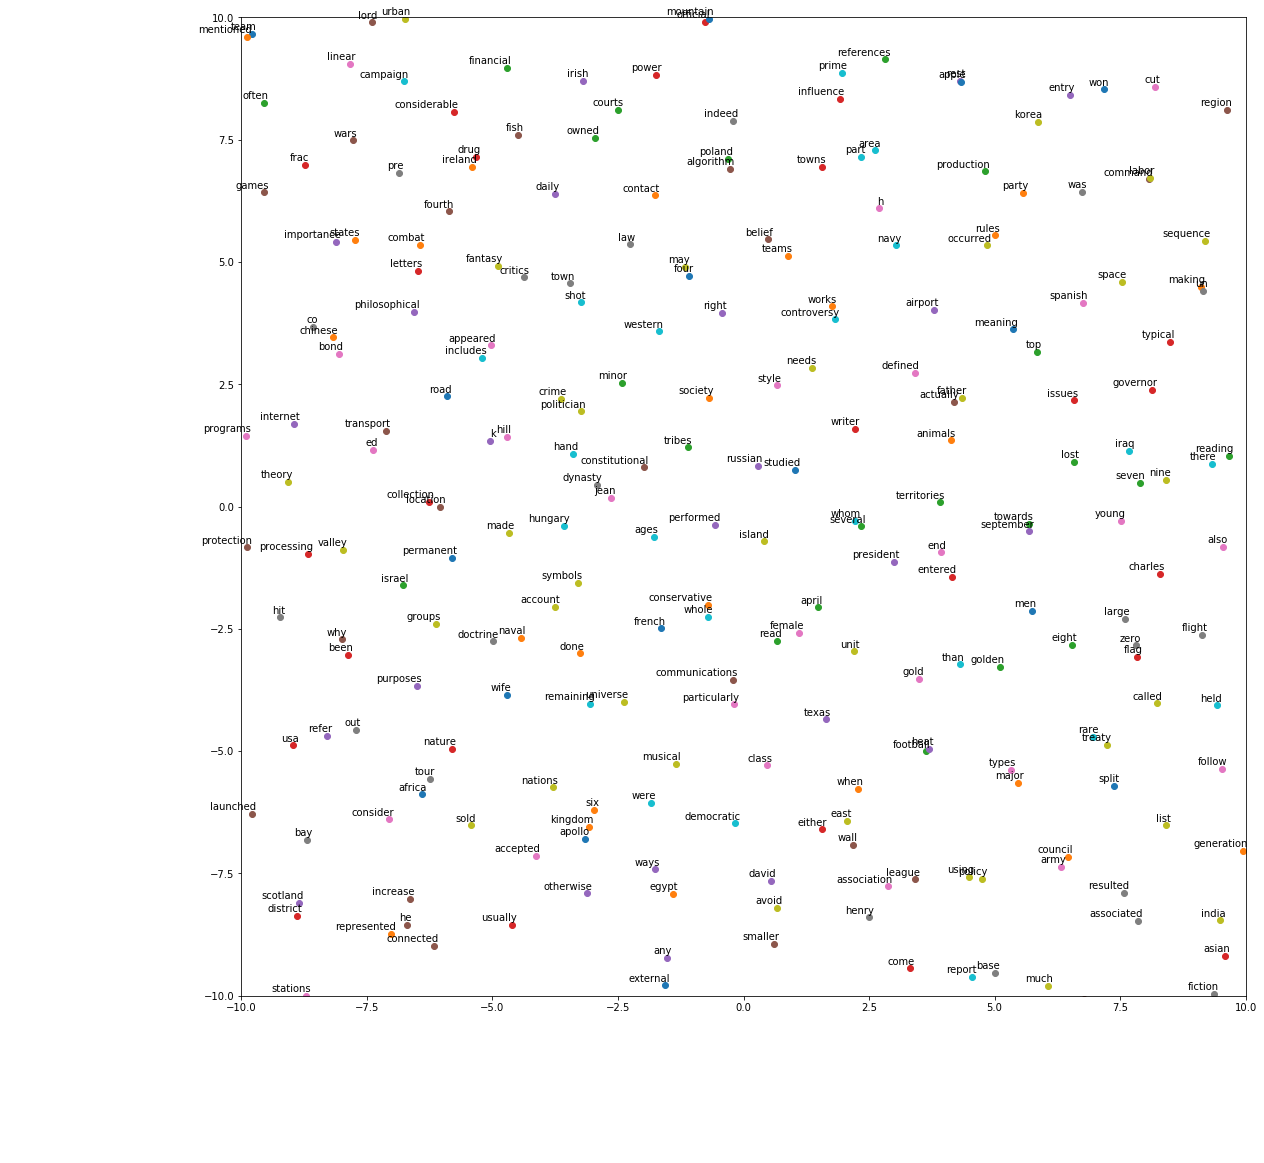

In [44]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

## Schaue dir auch folgende Links an

https://radimrehurek.com/gensim/tutorial.html

https://stackoverflow.com/questions/40074412/word2vec-get-nearest-words

In [45]:
# np.save('trained_embeddings_200k_steps',final_embeddings)

# Gut gemacht! 